# CIFAR-10 CNN

CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

O conjunto de dados CIFAR-10 possui 60.000 imagens coloridas de dimensões $32\times 32$. Os dados são divididos em 10 classes com 6.000 imagens por classe. 

No exemplo abaixo nós utilizamos apenas 3 das 10 classes. A saída das diferentes camadas da CNN são mostradas.

## Importando as bibliotecas

In [1]:
%matplotlib inline

import os, sys
import numpy as np
import matplotlib.pylab as plt
from collections import OrderedDict

# from torch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler

# from torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

# from course libs
import lib.pytorch_trainer as ptt
from lib.cifar import CIFARX, CIFAR_CLASSES

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Carregando e mostrando os dados (seleciona apenas as classes 0, 1 e 2)

In [3]:
images_dir = '/data/datasets/CIFAR10/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()

# carrega somente as classes 0, 1 e 2 do CIFAR dos dados de treinamento e de teste
image_datasets = {
    'train': CIFARX(images_dir, [0, 1, 2], train=True, transform=data_transform),
    'val': CIFARX(images_dir, [0, 1, 2], train=False, transform=data_transform),
}

print('amostras para treinamento:', len(image_datasets['train']))
print('amostras para validação:', len(image_datasets['val']))

amostras para treinamento: 15000
amostras para validação: 3000


## Mostrando algumas imagens do conjunto de treinamento

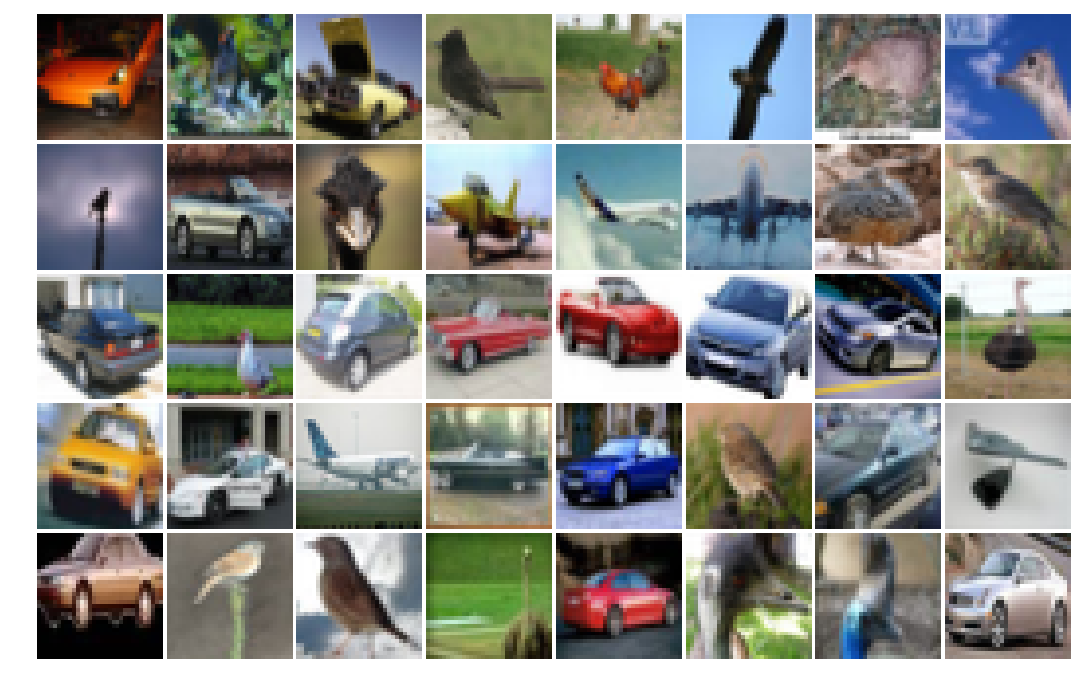

In [4]:
n_samples = 40

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_dataloader = torch.utils.data.DataLoader(image_datasets['train'], 
                                              batch_size=n_samples,
                                              shuffle=True, num_workers=4)

# pega um batch de imagens
image_batch, labels = next(iter(temp_dataloader))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)

plt.figure(figsize=(24, 12))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Teste inicial com pouquíssimas amostras

In [5]:
testing = False
if testing:
    n_samples = 3000
    image_datasets['train'].train_data = image_datasets['train'].train_data[:n_samples]
    image_datasets['train'].train_labels = image_datasets['train'].train_labels[:n_samples]
    
    n_samples_test = 500
    image_datasets['val'].test_data = image_datasets['val'].test_data[:n_samples_test]
    image_datasets['val'].test_labels = image_datasets['val'].test_labels[:n_samples_test]

## Cria o DataLoader para os dados

In [6]:
batch_size = 100

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                         shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size,
                                         shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val'])
}

class_names = image_datasets['train'].classes

print('Tamanho do conjunto de treinamento:', dataset_sizes['train'])
print('Tamanho do conjunto de validacao:', dataset_sizes['val'])
print('Classes:', class_names)

Tamanho do conjunto de treinamento: 15000
Tamanho do conjunto de validacao: 3000
Classes: ['airplane' 'automobile' 'bird']


# Construíndo a CNN com o PyTorch

<img src = '../figures/Rede_LeNet_Cifar.png', width=600pt></img>

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', nn.ReLU()),
            ('max_pool', nn.MaxPool2d(2)),
            ('drop', nn.Dropout(p=0.25))
        ]))
        
        # Camadas densas
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(in_features=14*14*32, out_features=128)),
            ('relu1', nn.ReLU()),
            ('drop1', nn.Dropout(p=0.5)),
            ('dense2', nn.Linear(in_features=128, out_features=3)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 14*14*32)  # Transforma a matriz em vetor
        x = self.dense_layer(x)
        
        return x

In [8]:
model = MyModel()

# input do mesmo tamanho que as imagens usadas
example_input = Variable(torch.zeros(1, 3, 32, 32))

# output da camada convolucional
example_output = model.conv_layer(example_input)

print('Dimensões da saída convolucional:', example_output.size())
print('Dimensão após a vetorização:', example_output.view(1, -1).size())

Dimensões da saída convolucional: torch.Size([1, 32, 14, 14])
Dimensão após a vetorização: torch.Size([1, 6272])


In [9]:
model = MyModel()
print(model)

MyModel (
  (conv_layer): Sequential (
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU ()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU ()
    (max_pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (drop): Dropout (p = 0.25)
  )
  (dense_layer): Sequential (
    (dense1): Linear (6272 -> 128)
    (relu1): ReLU ()
    (drop1): Dropout (p = 0.5)
    (dense2): Linear (128 -> 3)
  )
)


## Treinamento da rede

In [10]:
model = MyModel()
if use_gpu:
    model = model.cuda()

# Define o otimizador
optimizer = torch.optim.Adam(model.parameters())

# Define a função de perda
criterion = nn.CrossEntropyLoss()

# Define a acurácia para ser calculada no treinamento
def accuracy(out, y):
    _, y_hat = torch.max(out, 1)
    return torch.sum(y_hat==y) / y_hat.size(0)

# Nossa metrica apresentará a acurácia atual
metrics = {'acc': accuracy}

# Cria o objeto para treinar a rede
trainer = ptt.DeepNetTrainer(
    model=model,
    criterion=criterion, 
    optimizer=optimizer,
    # Diminui o valor de lr por um fator de 0.1 a cada 7 epocas
    lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
    #metrics=metrics
)

In [11]:
trainer.fit_loader(n_epochs=25, train_data=dataloaders['train'], valid_data=dataloaders['val'])

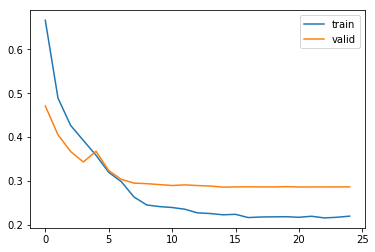

In [12]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt_train = plt.plot(epochs, train_loss, label='train')
plt_valid = plt.plot(epochs, valid_loss, label='valid')
plt.legend()
plt.show()

## Avaliação do treinamento no conjunto de testes

In [13]:
def test_network(model, dataset, criterion, batch_size=32):
    temp_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                  shuffle=False, num_workers=4)
    
    # desliga o treinamento para nao executar o dropout
    model.train(False)
    
    loss_sum = 0.0
    hit_sum = 0.0
    all_preds = np.zeros(len(dataset)).astype(int)
    all_probs = np.zeros(len(dataset)).astype(float)
    for i, data in enumerate(temp_dataloader):
        inputs, labels = data
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
    
        outputs = model(inputs)
        loss_sum += criterion(outputs, labels)

        outputs = nn.functional.softmax(outputs)
        probs, preds = torch.max(outputs, 1)
        curr_img_index = i*temp_dataloader.batch_size
        all_preds[curr_img_index:curr_img_index+labels.size(0)] = preds.data.cpu().numpy()
        all_probs[curr_img_index:curr_img_index+labels.size(0)] = probs.data.cpu().numpy()
        hit_sum += torch.sum(preds.data==labels.data)
    
    loss = loss_sum.data.cpu()[0] / len(temp_dataloader)
    accuracy = hit_sum / len(dataset)
    
    print("\nAccuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))
    return (all_preds, all_probs)

In [14]:
# testa a rede e pega as classes e probabilidades de saída
y_hat, y_prob = test_network(model, image_datasets['val'], criterion)


Accuracy on the test data set: 89.07% [0.28644]


In [15]:
# outro modo de obter as predições
predicted_output = trainer.predict_loader(dataloaders['val'])
_, y_hat2 = torch.max(predicted_output, 1)
print(np.sum(y_hat2.numpy()-y_hat))  #y_hat é igual ao y_hat2

predict: 29/29 ok
0


In [16]:
y_test = np.array(image_datasets['val'].test_labels)
X_test = image_datasets['val'].test_data

In [17]:
np.set_printoptions(precision=3)
print('Rótulos conj. teste:', y_test[:10])
print('Rótulos previstos:  ',y_hat[:10])
print('probabilidades:\n', y_prob[:10])

Rótulos conj. teste: [0 1 1 0 0 2 0 2 1 0]
Rótulos previstos:   [0 1 1 0 0 2 2 1 1 0]
probabilidades:
 [ 0.933  0.981  0.999  0.887  0.76   0.997  0.649  0.864  0.704  0.964]


In [18]:
acc = (y_hat == y_test).sum() / y_hat.size
print('Acurácia:', acc)

Acurácia: 0.890666666667


### Matriz de confusão

In [19]:
from pandas import crosstab
crosstab(y_test, y_hat)

col_0,0,1,2
row_0,,,
0,873,39,88
1,50,920,30
2,100,21,879


## Predições certas com maior probabilidade

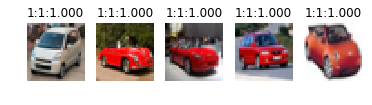

In [20]:
i_ok = np.where(y_hat==y_test)[0]
top_most_ok = np.argsort(y_prob[i_ok])[-5:][::-1]
y_top5 = i_ok[top_most_ok]

for k,i in enumerate(y_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i])
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições certas com menor probabilidade

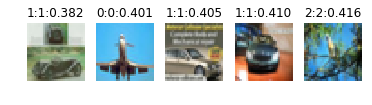

In [21]:
i_ok = np.where(y_hat==y_test)[0]
top_least_ok = np.argsort(y_prob[i_ok])[:5]
y_bot5 = i_ok[top_least_ok]
for k,i in enumerate(y_bot5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i])
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com maior probabilidade

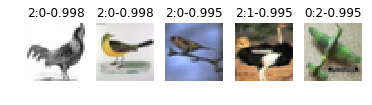

In [22]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_most_not_ok = np.argsort(y_prob[i_not_ok])[-5:][::-1]
y_most_not_ok_top5 = i_not_ok[top_most_not_ok]

for k,i in enumerate(y_most_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i])
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com menor probabilidade

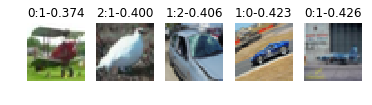

In [23]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_least_not_ok = np.argsort(y_prob[i_not_ok])[:5]
y_least_not_ok_top5 = i_not_ok[top_least_not_ok]

for k,i in enumerate(y_least_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i])
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Visualização de uma amostra

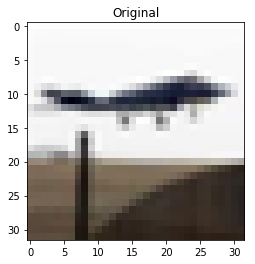

In [24]:
sample_number = 70  # amostra de número 70
plt.figure()
plt.imshow(X_test[sample_number])
#plt.axis('off')
plt.title("Original");

## Visualização das camadas internas

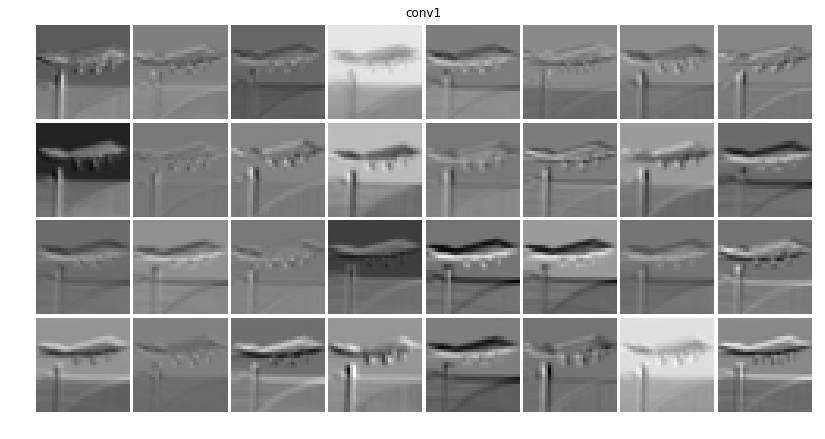

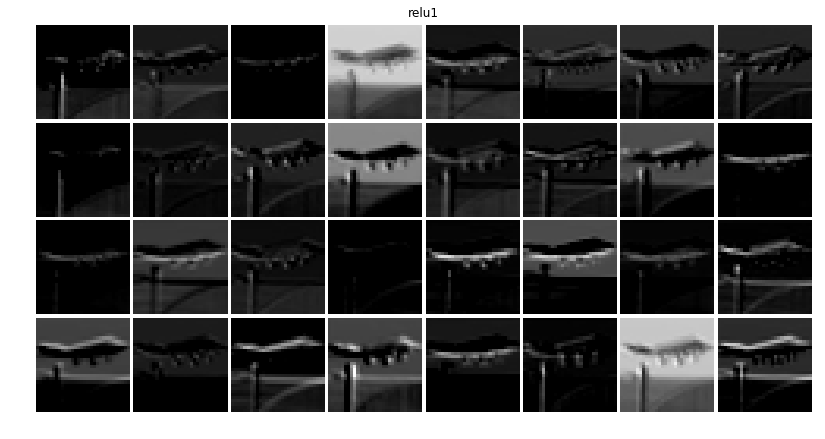

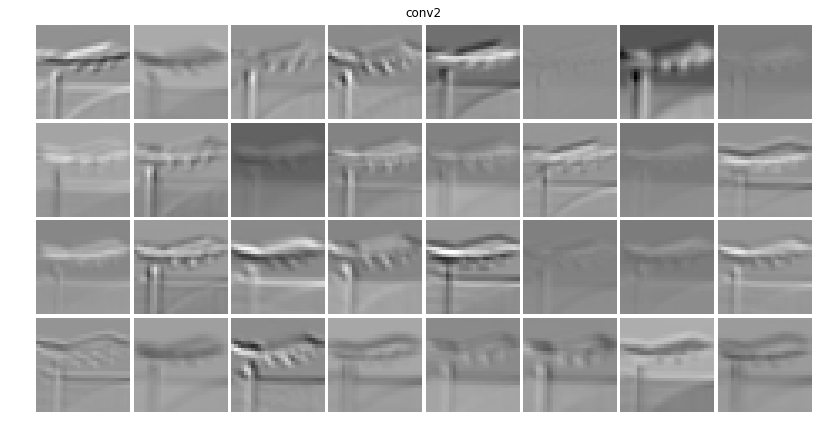

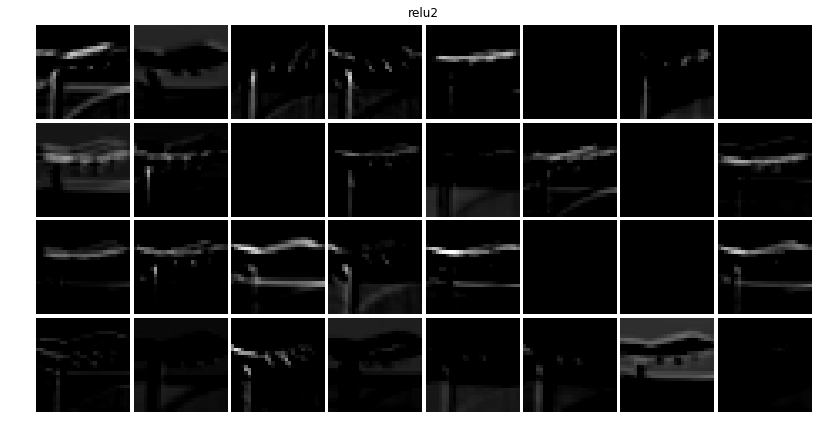

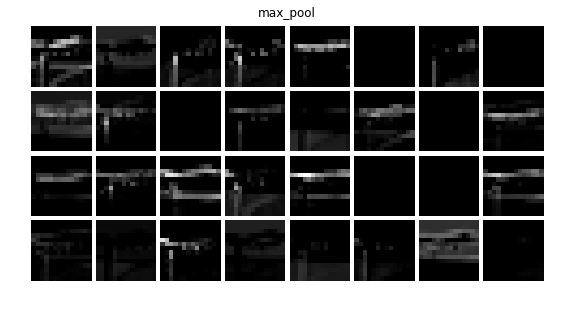

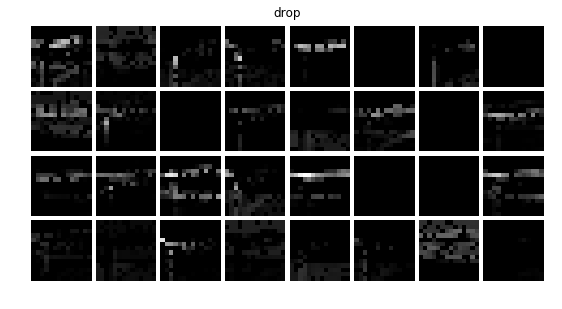

In [25]:
ncols = 8
H,W = 14,30

input, _ = image_datasets['val'][sample_number]
input = input.view(1, 3, 32, 32)

if use_gpu:
    x = Variable(input.cuda())
else:
    x = Variable(input)

model.train(True)

#Mostrando a saida das camadas convolucionais
for name, layer in model.conv_layer.named_children():
    x = layer(x)
    
    grid = torchvision.utils.make_grid(torch.transpose(x.data, 0, 1), normalize=True, 
                                       pad_value=1.0, padding=1).cpu().numpy()
    
    if name == 'max_pool':
        H /= 3/2
        W /= 3/2
    fig = plt.figure(figsize=(H,W))
    plt.imshow(grid.transpose((1,2,0)))
    plt.title(name)
    plt.axis('off')
    plt.show()


## Atividades

1. Quantos parâmetros são treinados nesta rede? Calcule o número de parâmetros de cada camada, não se esquecendo do *bias*.
2. Se as duas camadas convolucionais fossem densas, qual seria o número de parâmetros a serem treinados?
3. Altere o notebook para que ele seja processado na formato de imagens "channels_last".

## Aprendizados com este experimento
